In [2]:
import os
import sys
sys.path.append('/Users/mnannan/dev/supelec/ngsa/assignments/Assignement 2 ')

from main import pipeline
from core.io.loader import *
from features.features_extractor import FeaturesExtractor
from features.processing import features_processing
from models.cross_validation import *
from plot.features_importances import plot_features_importance

from datetime import datetime

%matplotlib inline



## Load dataset and extract features

In [3]:
train = get_data_with_node_information('train', data_dir='../data')
test = get_data_with_node_information('test', data_dir='../data')
features_extractor = FeaturesExtractor(pipeline)
train = features_extractor.fit_transform(train)
test = features_extractor.transform(test)

## Features selection

In [4]:
selected_columns = [
    'title_overlap',
    'publication_date_diff',
    'common_authors',
    'same_journal',
    'authors_collaboration',
    'collaboration_min_distance',
    'collaboration_mean_distance',
    'writer_in_target_paper',
    'writer_collaborators',
    'writer_collaboration_min_distance',
    'writer_collaboration_mean_distance',
    'source_paper_citations',
    'target_paper_citations',
    'source_number_of_papers_cited',
    'target_number_of_papers_cited',
    'adamic_adar',
    'common_neighbors',
    'jaccard_coefficient',
    'preferential_attachment'
]

x_train = features_processing(train[selected_columns]).values
x_test = features_processing(test[selected_columns]).values
y_train = train.category.values

### Model selection

In [11]:
from sklearn.ensemble import RandomForestClassifier

seed = 123

model_args = {
    'n_jobs': -1,
    'n_estimators': 100,
    'random_state': seed,
    'criterion': 'entropy'
}

### Cross validation

In [7]:
y_pred, f1_list = cross_validation(RandomForestClassifier, model_args, x_train, y_train)

Epoch 1
f1: 0.9720155862557562
Epoch 2
f1: 0.9723705981459515
Epoch 3
f1: 0.9717889546202821
Epoch 4
f1: 0.9726635848786264
Epoch 5
f1: 0.9722913555666168


In [8]:
np.mean(f1_list)

0.9722260158934466

### Train final model

adamic_adar                           0.297282
common_neighbors                      0.206559
jaccard_coefficient                   0.158734
publication_date_diff                 0.076522
target_paper_citations                0.064313
preferential_attachment               0.060561
source_number_of_papers_cited         0.034495
target_number_of_papers_cited         0.020367
title_overlap                         0.017136
source_paper_citations                0.016032
collaboration_mean_distance           0.014937
collaboration_min_distance            0.011142
writer_collaboration_mean_distance    0.010334
writer_collaboration_min_distance     0.004861
common_authors                        0.003432
same_journal                          0.001589
authors_collaboration                 0.000785
writer_collaborators                  0.000698
writer_in_target_paper                0.000221
dtype: float64


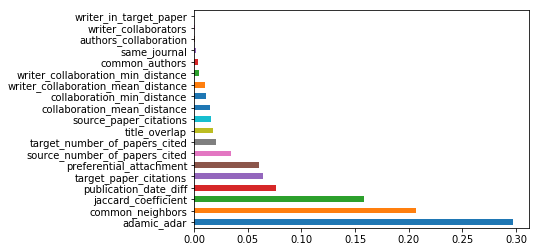

In [12]:
model = RandomForestClassifier(**model_args)
model.fit(x_train, y_train)
plot_features_importance(model.feature_importances_, selected_columns)

### Prediction on test

In [13]:
from datetime import datetime

In [14]:
date = datetime.now().isoformat().split(".")[0]
prediction_name = 'rf_graph_features_neighborhood_metrics_{date}.csv'.format(date=date)
prediction_dir = '../submissions'
y_pred = model.predict(x_test)
y_pred = pd.Series(data=y_pred).rename('category').rename_axis('id', axis='index')
y_pred.to_csv(os.path.join(prediction_dir, prediction_name), header=True)

# 0.96054 on the leaderboard